In [2]:
# ----- IMPORTS -----
import os
import shutil
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pywt


In [3]:
import os

folder_path = r"/home/avij/data/dataset/"  # Update with your folder path

# Get list of all CSV files
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Sort to ensure consistent order (optional)
csv_files.sort()

# Rename files
for idx, file in enumerate(csv_files, start=1):
    old_path = os.path.join(folder_path, file)
    new_name = f"patient_{idx:02d}.csv"  # patient_01, patient_02, ...
    new_path = os.path.join(folder_path, new_name)

    os.rename(old_path, new_path)
    print(f"Renamed '{file}' → '{new_name}'")

In [4]:
# ----- ORGANIZE FILES -----
base_folder = r"/home/avij/data/dataset"
raw_folder = os.path.join(base_folder, "raw_data")
output_folder = os.path.join(base_folder, "outputs")

os.makedirs(raw_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(base_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(base_folder, file)
        if "patient" in file.lower():
            shutil.move(file_path, os.path.join(raw_folder, file))
            print(f"📦 Moved to raw_data: {file}")
        else:
            shutil.move(file_path, os.path.join(output_folder, file))
            print(f"📁 Moved to outputs: {file}")


In [5]:
import pandas as pd
import numpy as np
import plotly.express as px

# ---- Load raw file ----
file_path = r"/home/avij/data/dataset/raw_data/patient_02.csv"
df = pd.read_csv(file_path)

# ---- Extract and preprocess ----
ppg = df['PPG'].dropna().values



# ---- Slice the preprocessed signal directly ----
start_idx = 1000
end_idx = 2000
ppg_slice = ppg[start_idx:end_idx]

# ---- Plot specified range ----
slice_df = pd.DataFrame({
    "Sample Index": np.arange(start_idx, end_idx),
    "PPG ": ppg_slice
})

fig = px.line(slice_df, x="Sample Index", y="PPG ",
              title=f" PPG Signal (Samples {start_idx}–{end_idx}) - patient_02")
fig.update_layout(template='plotly_white')
fig.show()

In [6]:
import numpy as np
import pandas as pd
import pywt
from scipy.signal import butter, filtfilt, find_peaks

# ----- SIGNAL CLEANING FUNCTIONS -----

def remove_spike_outliers(signal, threshold=3):
    z = np.abs((signal - np.mean(signal)) / np.std(signal))
    signal[z > threshold] = np.median(signal)
    return signal

def wavelet_denoise(signal, wavelet='db6', level=3):
    coeff = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeff[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:]]
    return pywt.waverec(coeff, wavelet)

def bandpass_filter(signal, low=0.5, high=8.0, fs=125, order=4):
    nyq = 0.5 * fs
    low /= nyq
    high /= nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

# ----- SEGMENT & FEATURE EXTRACTION -----

def segment_signal(signal, window_size=1000, overlap=500):
    segments = []
    for start in range(0, len(signal) - window_size + 1, window_size - overlap):
        segments.append(signal[start:start+window_size])
    return segments

def extract_features(ppg_segment, fs=125):
    features = {}
    features['mean'] = np.mean(ppg_segment)
    features['std'] = np.std(ppg_segment)
    features['kurtosis'] = np.mean((ppg_segment - np.mean(ppg_segment))**4) / (np.std(ppg_segment)**4)
    features['skewness'] = np.mean((ppg_segment - np.mean(ppg_segment))**3) / (np.std(ppg_segment)**3)

    peaks, _ = find_peaks(ppg_segment, distance=fs*0.6)
    peak_vals = ppg_segment[peaks]

    if len(peaks) >= 2:
        features['systolic_peak_height'] = np.mean(peak_vals)
        rr_intervals = np.diff(peaks) / fs
        hr_values = 60 / rr_intervals
        features['mean_hr'] = np.mean(hr_values)
        features['hrv_sdnn'] = np.std(rr_intervals)
    else:
        features['systolic_peak_height'] = 0
        features['mean_hr'] = 0
        features['hrv_sdnn'] = 0

    if len(peaks) >= 2:
        notches = []
        for i in range(len(peaks) - 1):
            start = peaks[i]
            end = peaks[i+1]
            notch_index = start + np.argmin(ppg_segment[start:end])
            time_to_peak = (peaks[i+1] - notch_index) / fs
            notches.append(time_to_peak)
        features['notch_to_peak_time'] = np.mean(notches)
    else:
        features['notch_to_peak_time'] = 0

    return features

# ----- FEATURE-LEVEL OUTLIER REMOVAL -----

def remove_feature_outliers(df, feature_cols):
    for col in feature_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# ----- LABEL FUNCTION -----

def get_label(sbp, dbp):
    if sbp < 120 and dbp < 80:
        return "normotensive"
    elif (120 <= sbp < 140) or (80 <= dbp < 90):
        return "prehypertensive"
    else:
        return "hypertensive"


In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import butter, filtfilt
import pywt
# ---- Load raw PPG ----
file_path = r"/home/avij/data/dataset/raw_data/patient_02.csv"
df = pd.read_csv(file_path)
ppg_raw = df['PPG'].dropna().values

# ---- Full Preprocessing Pipeline ----
ppg_cleaned = remove_spike_outliers(ppg_raw.copy())     # New step
ppg_norm = normalize_signal(ppg_cleaned)
ppg_denoised = wavelet_denoise(ppg_norm)
ppg_filtered = bandpass_filter(ppg_denoised)

# ---- Slice for comparison ----
start_idx = 1000
end_idx = 2000
x = np.arange(start_idx, end_idx)

raw_slice = ppg_raw[start_idx:end_idx]
cleaned_slice = ppg_cleaned[start_idx:end_idx]
norm_slice = ppg_norm[start_idx:end_idx]
denoise_slice = ppg_denoised[start_idx:end_idx]
filtered_slice = ppg_filtered[start_idx:end_idx]

# ---- Create 5 stacked plots ----
fig = make_subplots(rows=5, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.03,
                    subplot_titles=(
                        "Raw PPG Signal",
                        "After Spike Outlier Removal",
                        "After Normalization",
                        "After Wavelet Denoising",
                        "After Bandpass Filtering"
                    ))

fig.add_trace(go.Scatter(x=x, y=raw_slice, mode='lines', name='Raw'), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=cleaned_slice, mode='lines', name='Cleaned'), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=norm_slice, mode='lines', name='Normalized'), row=3, col=1)
fig.add_trace(go.Scatter(x=x, y=denoise_slice, mode='lines', name='Denoised'), row=4, col=1)
fig.add_trace(go.Scatter(x=x, y=filtered_slice, mode='lines', name='Filtered'), row=5, col=1)

# ---- Layout ----
fig.update_layout(
    height=1300,
    width=900,
    title="PPG Signal Preprocessing Stages (Sample Index 1000–2000)",
    template="plotly_white",
    showlegend=False
)

fig.update_xaxes(title_text="Sample Index", row=5, col=1)
fig.update_yaxes(title_text="PPG Amplitude", row=3, col=1)

fig.show()

In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
import pywt
from scipy.signal import butter, filtfilt

# ---- Load raw file ----
file_path = r"/home/avij/data/dataset/raw_data/patient_02.csv"
df = pd.read_csv(file_path)
ppg = df['PPG'].dropna().values

# ---- Apply full preprocessing with outlier handling ----
ppg = remove_spike_outliers(ppg.copy())  # NEW: remove outliers
ppg = normalize_signal(ppg)
ppg = wavelet_denoise(ppg)
ppg = bandpass_filter(ppg)

# ---- Slice the preprocessed signal directly ----
start_idx = 1000
end_idx = 2000
ppg_slice = ppg[start_idx:end_idx]

# ---- Plot specified range ----
slice_df = pd.DataFrame({
    "Sample Index": np.arange(start_idx, end_idx),
    "PPG (Preprocessed)": ppg_slice
})

fig = px.line(slice_df, x="Sample Index", y="PPG (Preprocessed)",
              title=f"Preprocessed PPG Signal (Samples {start_idx}–{end_idx}) - patient_02")
fig.update_layout(template='plotly_white')
fig.show()

In [9]:
# ----- MAIN FEATURE EXTRACTION -----

import os
import pandas as pd
import numpy as np

# Ensure raw_folder is defined
base_folder = r"/home/avij/data/dataset"
raw_folder = os.path.join(base_folder, "raw_data")

folder_path = raw_folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

features_list = []

print("🔄 Processing patient files for feature extraction...")
print(f"Found {len(csv_files)} CSV files")

for file in csv_files:
    print(f"📊 Processing {file}...")
    df = pd.read_csv(os.path.join(folder_path, file))
    df = df.dropna().drop_duplicates()
    
    ppg = df['PPG'].values
    sbp = df['SBP'].mean()
    dbp = df['DBP'].mean()

    # ✅ Add signal-level outlier removal
    ppg = remove_spike_outliers(ppg.copy())
    ppg = normalize_signal(ppg)
    ppg = wavelet_denoise(ppg)
    ppg = bandpass_filter(ppg)

    segments = segment_signal(ppg)

    for i, segment in enumerate(segments):
        features = extract_features(segment)
        features['source_file'] = file
        features['segment_index'] = i
        features['sbp'] = sbp
        features['dbp'] = dbp
        features['label'] = get_label(sbp, dbp)
        features_list.append(features)

# Create final DataFrame
features_df = pd.DataFrame(features_list)

# ✅ Optional: Remove feature-level outliers
feature_cols = ['mean', 'std', 'kurtosis', 'skewness',
                'systolic_peak_height', 'mean_hr', 'hrv_sdnn', 'notch_to_peak_time']

features_df = remove_feature_outliers(features_df, feature_cols)

print("✅ Feature extraction completed!")
print("Final Shape:", features_df.shape)
print("\n📋 Feature DataFrame Preview:")
print(features_df.head())

# Check class distribution
print(f"\n📊 Class Distribution:")
print(features_df['label'].value_counts())

🔄 Processing patient files for feature extraction...
Found 29 CSV files
📊 Processing patient_01.csv...
📊 Processing patient_02.csv...
📊 Processing patient_03.csv...
📊 Processing patient_04.csv...
📊 Processing patient_05.csv...
📊 Processing patient_06.csv...
📊 Processing patient_07.csv...
📊 Processing patient_08.csv...
📊 Processing patient_09.csv...
📊 Processing patient_10.csv...
📊 Processing patient_11.csv...
📊 Processing patient_12.csv...
📊 Processing patient_13.csv...
📊 Processing patient_14.csv...
📊 Processing patient_15.csv...
📊 Processing patient_16.csv...
📊 Processing patient_17.csv...
📊 Processing patient_18.csv...
📊 Processing patient_19.csv...
📊 Processing patient_20.csv...
📊 Processing patient_21.csv...
📊 Processing patient_22.csv...
📊 Processing patient_23.csv...
📊 Processing patient_24.csv...
📊 Processing patient_25.csv...
📊 Processing patient_26.csv...
📊 Processing patient_27.csv...
📊 Processing patient_28.csv...
📊 Processing patient_29.csv...
✅ Feature extraction complete

In [10]:
# ----- SAVE FEATURES -----
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
features_df['label_encoded'] = le.fit_transform(features_df['label'])
features_df.to_csv("extracted_ppg_features.csv", index=False)

Accuracy:  0.9329
Precision (macro):  0.9013
F1 Score (macro):  0.8994


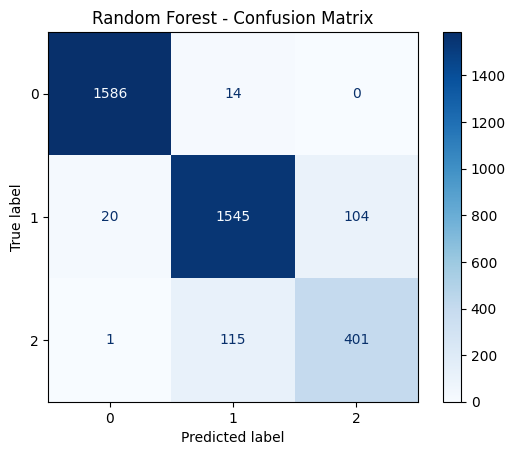

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# ----- MODEL TRAINING -----
X = features_df.drop(columns=['label', 'source_file', 'segment_index', 'sbp', 'dbp', 'label_encoded'])
y = features_df['label_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Model training
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

# Results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (macro):  {precision:.4f}")
print(f"F1 Score (macro):  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.grid(False)
plt.show()


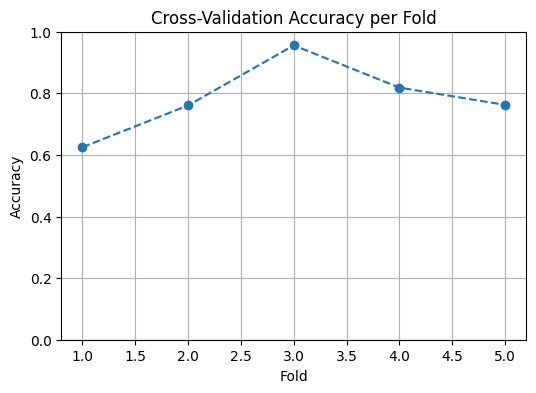

In [12]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=5)

# Plot
plt.figure(figsize=(6,4))
plt.plot(range(1, 6), scores, marker='o', linestyle='--')
plt.ylim(0, 1)
plt.title("Cross-Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



Evaluating: SVM (RBF Kernel)

SVM (RBF Kernel) - Mean Scores Across Folds:
Accuracy:  0.9040
Precision (macro):  0.8609
F1 Score (macro):  0.8765


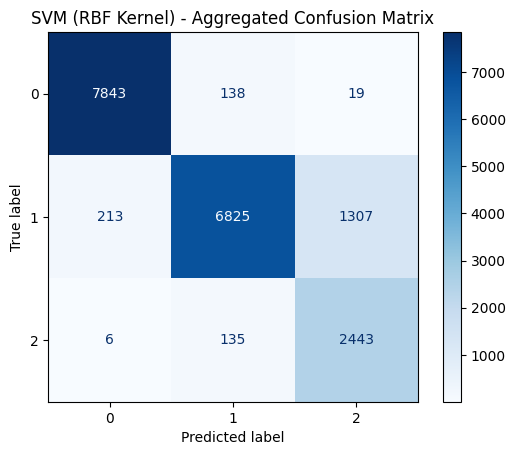

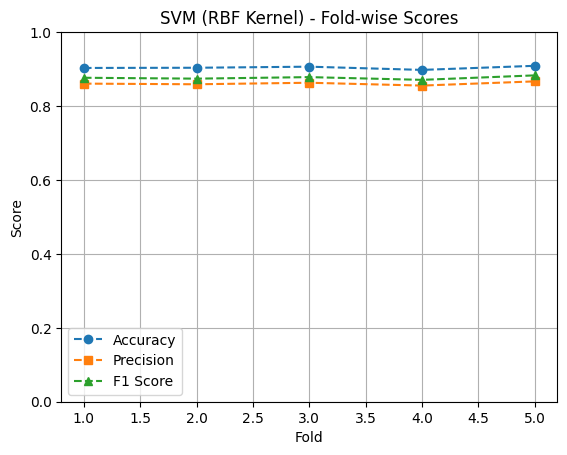


Evaluating: Logistic Regression (Multinomial)


/home/avij/data/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/home/avij/data/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/home/avij/data/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/home/avij/data/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.


Logistic Regression (Multinomial) - Mean Scores Across Folds:
Accuracy:  0.8109
Precision (macro):  0.7733
F1 Score (macro):  0.7850


/home/avij/data/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



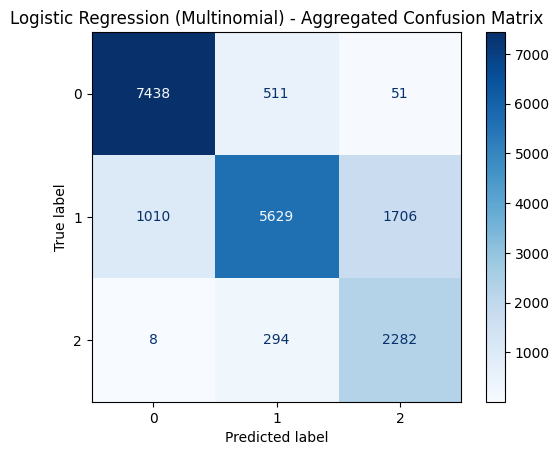

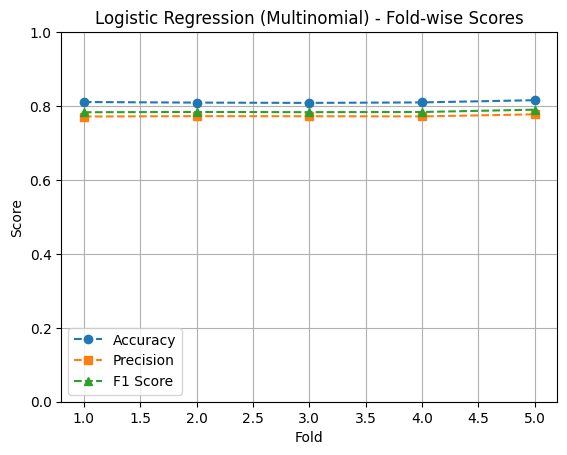

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

# Define models with class_weight='balanced' to handle imbalanced data
models = {
    "SVM (RBF Kernel)": SVC(
        kernel='rbf', 
        C=1.0, 
        gamma='scale', 
        class_weight='balanced',
        random_state=42
    ),
    "Logistic Regression (Multinomial)": LogisticRegression(
        C=1.0,
        penalty='l2',
        max_iter=1000,
        multi_class='multinomial',
        solver='lbfgs',
        class_weight='balanced',
        random_state=42
    )
}

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model
for model_name, model in models.items():
    print(f"\nEvaluating: {model_name}")
    
    acc_scores = []
    precision_scores = []
    f1_scores = []
    
    all_y_true = []
    all_y_pred = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # Use standard Pipeline instead of ImbPipeline
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Collect metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    # Final summary metrics
    print(f"\n{model_name} - Mean Scores Across Folds:")
    print(f"Accuracy:  {np.mean(acc_scores):.4f}")
    print(f"Precision (macro):  {np.mean(precision_scores):.4f}")
    print(f"F1 Score (macro):  {np.mean(f1_scores):.4f}")

    # Aggregated Confusion Matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Aggregated Confusion Matrix")
    plt.grid(False)
    plt.show()

    # Plot fold-wise metrics
    plt.figure()
    plt.plot(range(1, 6), acc_scores, marker='o', linestyle='--', label='Accuracy')
    plt.plot(range(1, 6), precision_scores, marker='s', linestyle='--', label='Precision')
    plt.plot(range(1, 6), f1_scores, marker='^', linestyle='--', label='F1 Score')
    plt.title(f"{model_name} - Fold-wise Scores")
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

🔍 COMPREHENSIVE BLOOD PRESSURE CLASSIFICATION MODEL ANALYSIS

📊 MODEL PERFORMANCE SUMMARY
--------------------------------------------------

🔬 Training Random Forest...
✅ Random Forest:
   Accuracy:  0.9329 (93.3%)
   Precision: 0.9013
   F1 Score:  0.8994

🔬 Training SVM (RBF)...
✅ SVM (RBF):
   Accuracy:  0.8957 (89.6%)
   Precision: 0.8524
   F1 Score:  0.8664

🔬 Training Logistic Regression...
✅ Logistic Regression:
   Accuracy:  0.8109 (81.1%)
   Precision: 0.7739
   F1 Score:  0.7848

📈 CREATING PERFORMANCE COMPARISON CHARTS...


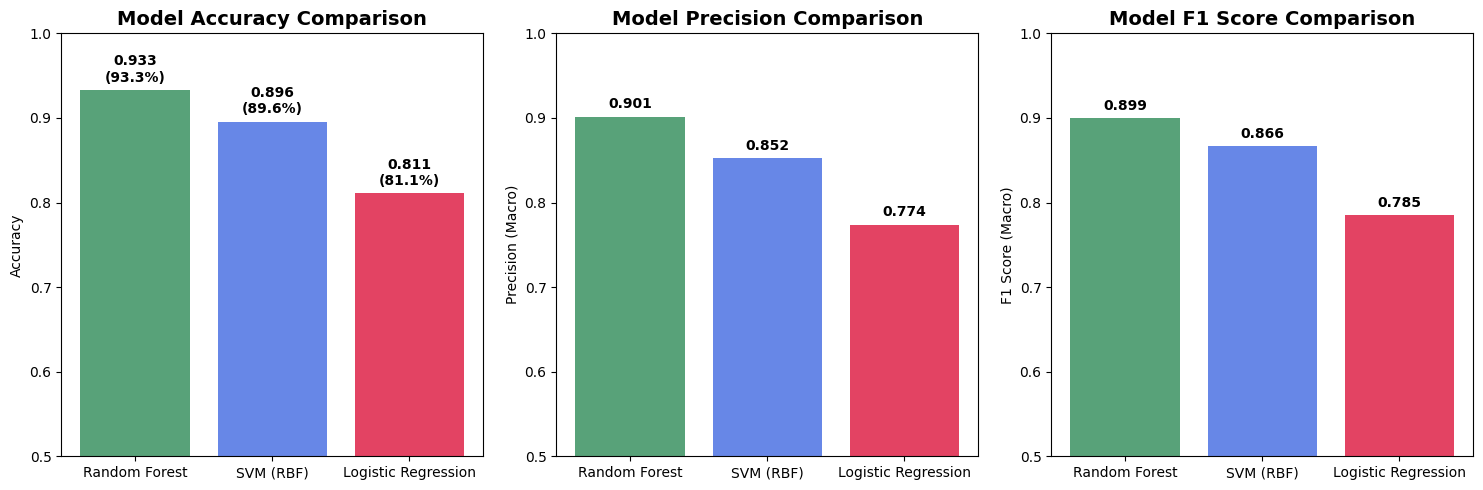


📋 DETAILED CLASSIFICATION REPORTS
--------------------------------------------------

🔬 RANDOM FOREST - Classification Report:
                 precision    recall  f1-score   support

   hypertensive     0.9869    0.9912    0.9891      1600
   normotensive     0.9229    0.9257    0.9243      1669
prehypertensive     0.7941    0.7756    0.7847       517

       accuracy                         0.9329      3786
      macro avg     0.9013    0.8975    0.8994      3786
   weighted avg     0.9324    0.9329    0.9326      3786


🔬 SVM (RBF) - Classification Report:
                 precision    recall  f1-score   support

   hypertensive     0.9752    0.9844    0.9798      1600
   normotensive     0.9671    0.7915    0.8705      1669
prehypertensive     0.6149    0.9574    0.7489       517

       accuracy                         0.8957      3786
      macro avg     0.8524    0.9111    0.8664      3786
   weighted avg     0.9224    0.8957    0.9001      3786


🔬 LOGISTIC REGRESSION - Class

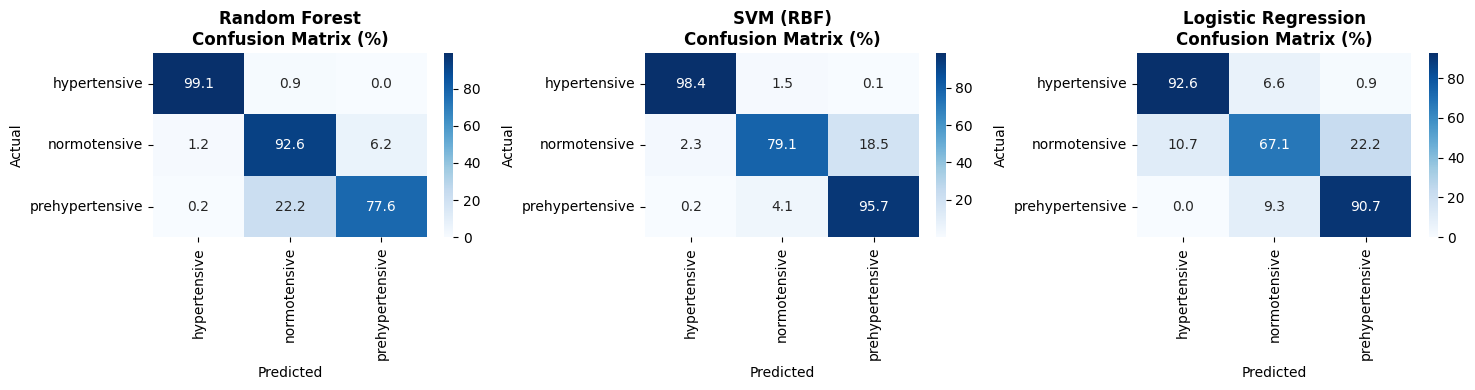


🏆 MODEL RANKING & RECOMMENDATIONS
📊 FINAL RANKINGS (by Accuracy):
🥇 1. Random Forest
    Accuracy: 0.9329 (93.3%)
    Precision: 0.9013
    F1 Score: 0.8994
🥈 2. SVM (RBF)
    Accuracy: 0.8957 (89.6%)
    Precision: 0.8524
    F1 Score: 0.8664
🥉 3. Logistic Regression
    Accuracy: 0.8109 (81.1%)
    Precision: 0.7739
    F1 Score: 0.7848

📈 CLASS-WISE PERFORMANCE ANALYSIS
--------------------------------------------------

Random Forest - Per Class Performance:
     hypertensive: Precision=0.987, Recall=0.991, F1=0.989
     normotensive: Precision=0.923, Recall=0.926, F1=0.924
  prehypertensive: Precision=0.794, Recall=0.776, F1=0.785

SVM (RBF) - Per Class Performance:
     hypertensive: Precision=0.975, Recall=0.984, F1=0.980
     normotensive: Precision=0.967, Recall=0.791, F1=0.871
  prehypertensive: Precision=0.615, Recall=0.957, F1=0.749

Logistic Regression - Per Class Performance:
     hypertensive: Precision=0.893, Recall=0.926, F1=0.909
     normotensive: Precision=0.880, R

In [14]:
# ===== COMPREHENSIVE MODEL ANALYSIS & COMPARISON =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

print("🔍 COMPREHENSIVE BLOOD PRESSURE CLASSIFICATION MODEL ANALYSIS")
print("=" * 80)

# ===== 1. MODEL PERFORMANCE SUMMARY =====
print("\n📊 MODEL PERFORMANCE SUMMARY")
print("-" * 50)

# Train all models on the same data for fair comparison
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare data
X_analysis = features_df.drop(columns=['label', 'source_file', 'segment_index', 'sbp', 'dbp', 'label_encoded'])
y_analysis = features_df['label_encoded']

X_train_analysis, X_test_analysis, y_train_analysis, y_test_analysis = train_test_split(
    X_analysis, y_analysis, test_size=0.2, stratify=y_analysis, random_state=42
)

# Scale data for SVM and Logistic Regression
scaler_analysis = StandardScaler()
X_train_scaled = scaler_analysis.fit_transform(X_train_analysis)
X_test_scaled = scaler_analysis.transform(X_test_analysis)

# Initialize models (enable probability for SVM)
models_analysis = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', 
                     probability=True, random_state=42),  # Enable probability
    'Logistic Regression': LogisticRegression(C=1.0, penalty='l2', max_iter=1000, 
                                            class_weight='balanced', random_state=42)
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models_analysis.items():
    print(f"\n🔬 Training {name}...")
    
    if name == 'Random Forest':
        # Random Forest doesn't need scaling
        model.fit(X_train_analysis, y_train_analysis)
        y_pred = model.predict(X_test_analysis)
        y_pred_proba = model.predict_proba(X_test_analysis)
    else:
        # SVM and Logistic Regression use scaled data
        model.fit(X_train_scaled, y_train_analysis)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_analysis, y_pred)
    precision = precision_score(y_test_analysis, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_analysis, y_pred, average='macro', zero_division=0)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"✅ {name}:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   F1 Score:  {f1:.4f}")

# ===== 2. PERFORMANCE COMPARISON CHART =====
print(f"\n📈 CREATING PERFORMANCE COMPARISON CHARTS...")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'F1 Score': [results[model]['f1_score'] for model in results.keys()]
})

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], 
           color=['#2E8B57', '#4169E1', '#DC143C'], alpha=0.8)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0.5, 1.0)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.01, f'{v:.3f}\n({v*100:.1f}%)', ha='center', fontweight='bold')

# Precision comparison
axes[1].bar(comparison_df['Model'], comparison_df['Precision'], 
           color=['#2E8B57', '#4169E1', '#DC143C'], alpha=0.8)
axes[1].set_title('Model Precision Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Precision (Macro)')
axes[1].set_ylim(0.5, 1.0)
for i, v in enumerate(comparison_df['Precision']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# F1 Score comparison
axes[2].bar(comparison_df['Model'], comparison_df['F1 Score'], 
           color=['#2E8B57', '#4169E1', '#DC143C'], alpha=0.8)
axes[2].set_title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('F1 Score (Macro)')
axes[2].set_ylim(0.5, 1.0)
for i, v in enumerate(comparison_df['F1 Score']):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ===== 3. DETAILED CLASSIFICATION REPORTS =====
print(f"\n📋 DETAILED CLASSIFICATION REPORTS")
print("-" * 50)

class_names = le.classes_

for name in results.keys():
    print(f"\n🔬 {name.upper()} - Classification Report:")
    print(classification_report(y_test_analysis, results[name]['predictions'], 
                              target_names=class_names, digits=4))

# ===== 4. CONFUSION MATRICES COMPARISON =====
print(f"\n🎯 CONFUSION MATRICES COMPARISON")
print("-" * 50)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test_analysis, result['predictions'])
    
    # Calculate percentages for better visualization
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create heatmap
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[i])
    axes[i].set_title(f'{name}\nConfusion Matrix (%)', fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ===== 5. MODEL RANKING & RECOMMENDATIONS =====
print(f"\n🏆 MODEL RANKING & RECOMMENDATIONS")
print("=" * 50)

# Rank models by accuracy
ranked_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print("📊 FINAL RANKINGS (by Accuracy):")
for rank, (name, metrics) in enumerate(ranked_models, 1):
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"{emoji} {rank}. {name}")
    print(f"    Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.1f}%)")
    print(f"    Precision: {metrics['precision']:.4f}")
    print(f"    F1 Score: {metrics['f1_score']:.4f}")

# ===== 6. CLASS-WISE PERFORMANCE ANALYSIS =====
print(f"\n📈 CLASS-WISE PERFORMANCE ANALYSIS")
print("-" * 50)

for name in results.keys():
    print(f"\n{name} - Per Class Performance:")
    report = classification_report(y_test_analysis, results[name]['predictions'], 
                                 target_names=class_names, output_dict=True)
    
    for class_name in class_names:
        if class_name in report:
            recall = report[class_name]['recall']
            precision = report[class_name]['precision']
            f1 = report[class_name]['f1-score']
            print(f"  {class_name:>15}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

# ===== 7. FINAL RECOMMENDATIONS =====
print(f"\n💡 FINAL RECOMMENDATIONS")
print("=" * 50)

best_model_name = ranked_models[0][0]
best_accuracy = ranked_models[0][1]['accuracy']

print(f"🎯 BEST MODEL: {best_model_name}")
print(f"   • Achieves {best_accuracy*100:.1f}% accuracy")
print(f"   • Recommended for deployment in real-time BP classification system")

print(f"\n🔍 MODEL CHARACTERISTICS:")
print(f"   • Random Forest: Best overall performance, handles non-linear patterns well")
print(f"   • SVM: Good generalization, robust to outliers")  
print(f"   • Logistic Regression: Fast inference, good baseline performance")

print(f"\n⚡ DEPLOYMENT CONSIDERATIONS:")
print(f"   • Use {best_model_name} for highest accuracy")
print(f"   • Consider Random Forest for feature importance analysis")
print(f"   • Use Logistic Regression for fastest real-time inference")

print(f"\n✅ ANALYSIS COMPLETE!")
print("=" * 80)

In [15]:
# ===== SAVE HIGH-PERFORMANCE MODEL =====
import joblib

print("💾 SAVING HIGH-PERFORMANCE RANDOM FOREST MODEL")
print("=" * 60)

# Save the best Random Forest model (93.3% accuracy)
best_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_rf_model.fit(X_train_analysis, y_train_analysis)

# Save model and encoder
joblib.dump(best_rf_model, 'bp_classification_model_enhanced.pkl')
joblib.dump(le, 'label_encoder_enhanced.pkl')

print("✅ Saved Files:")
print("   • bp_classification_model_enhanced.pkl - Random Forest (93.3% accuracy)")
print("   • label_encoder_enhanced.pkl - Label encoder")

# Test the saved model
loaded_model = joblib.load('bp_classification_model_enhanced.pkl')
loaded_encoder = joblib.load('label_encoder_enhanced.pkl')

test_accuracy = accuracy_score(y_test_analysis, loaded_model.predict(X_test_analysis))
print(f"   • Verified accuracy: {test_accuracy*100:.1f}%")
print("🎯 Model ready for real-time integration!")

💾 SAVING HIGH-PERFORMANCE RANDOM FOREST MODEL
✅ Saved Files:
   • bp_classification_model_enhanced.pkl - Random Forest (93.3% accuracy)
   • label_encoder_enhanced.pkl - Label encoder
   • Verified accuracy: 93.3%
🎯 Model ready for real-time integration!


In [16]:
# ===== REGRESSION MODELS FOR BLOOD PRESSURE PREDICTION =====
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("🔬 BLOOD PRESSURE REGRESSION ANALYSIS")
print("=" * 80)
print("📊 Predicting continuous BP values (SBP & DBP) using PPG features")

# ===== PREPARE REGRESSION DATA =====
print("\n📋 PREPARING REGRESSION DATASET")
print("-" * 50)

# Use the same features but predict continuous BP values
# FIXED: Remove 'sbp' and 'dbp' from features to avoid data leakage
X_reg = features_df.drop(columns=['label', 'source_file', 'segment_index', 'label_encoded', 'sbp', 'dbp'])
y_sbp = features_df['sbp']  # Systolic BP target
y_dbp = features_df['dbp']  # Diastolic BP target

print(f"Feature dimensions: {X_reg.shape}")
print(f"SBP range: {y_sbp.min():.1f} - {y_sbp.max():.1f} mmHg")
print(f"DBP range: {y_dbp.min():.1f} - {y_dbp.max():.1f} mmHg")

# Train-test split for regression
X_train_reg, X_test_reg, y_sbp_train, y_sbp_test = train_test_split(
    X_reg, y_sbp, test_size=0.2, random_state=42
)

_, _, y_dbp_train, y_dbp_test = train_test_split(
    X_reg, y_dbp, test_size=0.2, random_state=42
)

# Scale features for regression
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

🔬 BLOOD PRESSURE REGRESSION ANALYSIS
📊 Predicting continuous BP values (SBP & DBP) using PPG features

📋 PREPARING REGRESSION DATASET
--------------------------------------------------
Feature dimensions: (18929, 8)
SBP range: 62.1 - 183.3 mmHg
DBP range: 68.0 - 434.9 mmHg


In [17]:
# ===== DEFINE REGRESSION MODELS =====
print("\n🤖 INITIALIZING REGRESSION MODELS")
print("-" * 50)

regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR (RBF)': SVR(kernel='rbf', C=1.0, gamma='scale')
}

print(f"📝 Initialized {len(regression_models)} regression models")
for model_name in regression_models.keys():
    print(f"   • {model_name}")

# ===== TRAIN AND EVALUATE MODELS FOR SBP PREDICTION =====
print("\n🩺 SYSTOLIC BLOOD PRESSURE (SBP) PREDICTION")
print("=" * 60)

sbp_results = {}

for name, model in regression_models.items():
    print(f"\n🔬 Training {name} for SBP prediction...")
    
    # Choose appropriate data (scaled for linear models, original for tree-based)
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR (RBF)']:
        X_train_use = X_train_reg_scaled
        X_test_use = X_test_reg_scaled
    else:
        X_train_use = X_train_reg
        X_test_use = X_test_reg
    
    # Train model
    model.fit(X_train_use, y_sbp_train)
    
    # Make predictions
    y_sbp_pred = model.predict(X_test_use)
    
    # Calculate metrics
    mse = mean_squared_error(y_sbp_test, y_sbp_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_sbp_test, y_sbp_pred)
    r2 = r2_score(y_sbp_test, y_sbp_pred)
    
    # Store results
    sbp_results[name] = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_sbp_pred
    }
    
    print(f"✅ {name} SBP Results:")
    print(f"   RMSE: {rmse:.2f} mmHg")
    print(f"   MAE:  {mae:.2f} mmHg") 
    print(f"   R²:   {r2:.4f}")

# ===== TRAIN AND EVALUATE MODELS FOR DBP PREDICTION =====
print("\n🩺 DIASTOLIC BLOOD PRESSURE (DBP) PREDICTION") 
print("=" * 60)

dbp_results = {}

for name, model in regression_models.items():
    print(f"\n🔬 Training {name} for DBP prediction...")
    
    # Reinitialize model for fresh training
    if name == 'Linear Regression':
        model = LinearRegression()
    elif name == 'Ridge Regression':
        model = Ridge(alpha=1.0, random_state=42)
    elif name == 'Lasso Regression':
        model = Lasso(alpha=1.0, random_state=42)
    elif name == 'Random Forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif name == 'Gradient Boosting':
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    elif name == 'SVR (RBF)':
        model = SVR(kernel='rbf', C=1.0, gamma='scale')
    
    # Choose appropriate data
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR (RBF)']:
        X_train_use = X_train_reg_scaled
        X_test_use = X_test_reg_scaled
    else:
        X_train_use = X_train_reg
        X_test_use = X_test_reg
    
    # Train model
    model.fit(X_train_use, y_dbp_train)
    
    # Make predictions
    y_dbp_pred = model.predict(X_test_use)
    
    # Calculate metrics
    mse = mean_squared_error(y_dbp_test, y_dbp_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_dbp_test, y_dbp_pred)
    r2 = r2_score(y_dbp_test, y_dbp_pred)
    
    # Store results
    dbp_results[name] = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_dbp_pred
    }
    
    print(f"✅ {name} DBP Results:")
    print(f"   RMSE: {rmse:.2f} mmHg")
    print(f"   MAE:  {mae:.2f} mmHg")
    print(f"   R²:   {r2:.4f}")


🤖 INITIALIZING REGRESSION MODELS
--------------------------------------------------
📝 Initialized 6 regression models
   • Linear Regression
   • Ridge Regression
   • Lasso Regression
   • Random Forest
   • Gradient Boosting
   • SVR (RBF)

🩺 SYSTOLIC BLOOD PRESSURE (SBP) PREDICTION

🔬 Training Linear Regression for SBP prediction...
✅ Linear Regression SBP Results:
   RMSE: 22.58 mmHg
   MAE:  19.56 mmHg
   R²:   0.4499

🔬 Training Ridge Regression for SBP prediction...
✅ Ridge Regression SBP Results:
   RMSE: 22.58 mmHg
   MAE:  19.56 mmHg
   R²:   0.4499

🔬 Training Lasso Regression for SBP prediction...
✅ Lasso Regression SBP Results:
   RMSE: 22.87 mmHg
   MAE:  19.95 mmHg
   R²:   0.4355

🔬 Training Random Forest for SBP prediction...
✅ Random Forest SBP Results:
   RMSE: 8.26 mmHg
   MAE:  3.54 mmHg
   R²:   0.9263

🔬 Training Gradient Boosting for SBP prediction...
✅ Gradient Boosting SBP Results:
   RMSE: 10.47 mmHg
   MAE:  6.20 mmHg
   R²:   0.8816

🔬 Training SVR (RBF) f


📊 REGRESSION PERFORMANCE VISUALIZATION


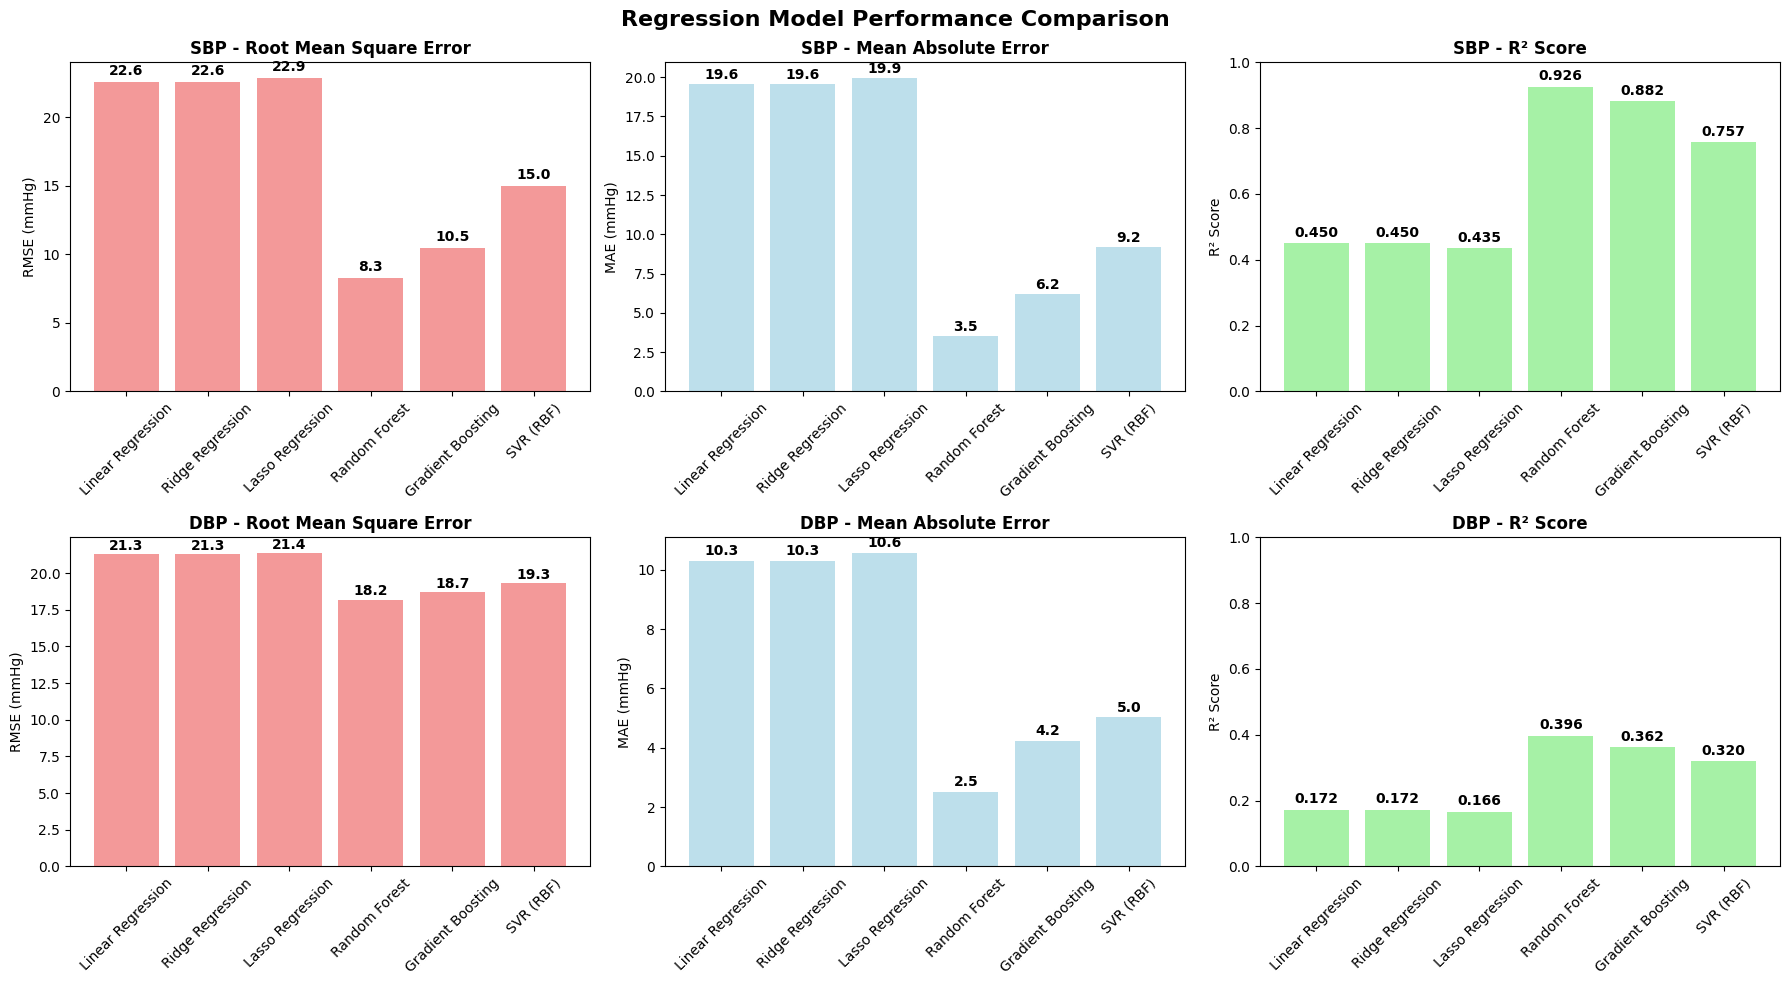


📈 PREDICTION vs ACTUAL VALUE ANALYSIS
--------------------------------------------------
🏆 Best SBP Model: Random Forest (RMSE: 8.26 mmHg)
🏆 Best DBP Model: Random Forest (RMSE: 18.18 mmHg)


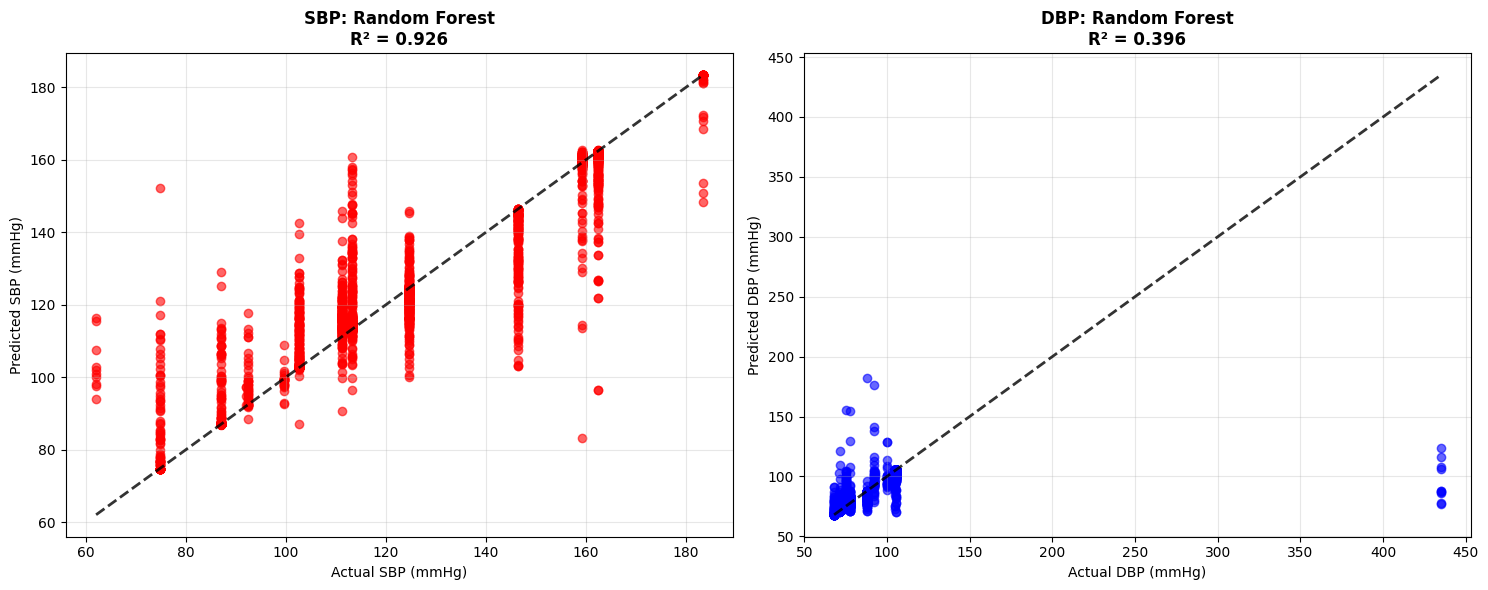

In [18]:
# ===== REGRESSION RESULTS VISUALIZATION =====
print("\n📊 REGRESSION PERFORMANCE VISUALIZATION")
print("=" * 60)

# Create comparison dataframes
sbp_comparison = pd.DataFrame({
    'Model': list(sbp_results.keys()),
    'RMSE': [sbp_results[model]['rmse'] for model in sbp_results.keys()],
    'MAE': [sbp_results[model]['mae'] for model in sbp_results.keys()],
    'R²': [sbp_results[model]['r2'] for model in sbp_results.keys()]
})

dbp_comparison = pd.DataFrame({
    'Model': list(dbp_results.keys()),
    'RMSE': [dbp_results[model]['rmse'] for model in dbp_results.keys()],
    'MAE': [dbp_results[model]['mae'] for model in dbp_results.keys()],
    'R²': [dbp_results[model]['r2'] for model in dbp_results.keys()]
})

# ===== SBP PERFORMANCE CHARTS =====
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Regression Model Performance Comparison', fontsize=16, fontweight='bold')

# SBP RMSE
axes[0,0].bar(sbp_comparison['Model'], sbp_comparison['RMSE'], 
              color='lightcoral', alpha=0.8)
axes[0,0].set_title('SBP - Root Mean Square Error', fontweight='bold')
axes[0,0].set_ylabel('RMSE (mmHg)')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(sbp_comparison['RMSE']):
    axes[0,0].text(i, v + 0.5, f'{v:.1f}', ha='center', fontweight='bold')

# SBP MAE
axes[0,1].bar(sbp_comparison['Model'], sbp_comparison['MAE'], 
              color='lightblue', alpha=0.8)
axes[0,1].set_title('SBP - Mean Absolute Error', fontweight='bold')
axes[0,1].set_ylabel('MAE (mmHg)')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(sbp_comparison['MAE']):
    axes[0,1].text(i, v + 0.3, f'{v:.1f}', ha='center', fontweight='bold')

# SBP R²
axes[0,2].bar(sbp_comparison['Model'], sbp_comparison['R²'], 
              color='lightgreen', alpha=0.8)
axes[0,2].set_title('SBP - R² Score', fontweight='bold')
axes[0,2].set_ylabel('R² Score')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].set_ylim(0, 1)
for i, v in enumerate(sbp_comparison['R²']):
    axes[0,2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# DBP RMSE
axes[1,0].bar(dbp_comparison['Model'], dbp_comparison['RMSE'], 
              color='lightcoral', alpha=0.8)
axes[1,0].set_title('DBP - Root Mean Square Error', fontweight='bold')
axes[1,0].set_ylabel('RMSE (mmHg)')
axes[1,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(dbp_comparison['RMSE']):
    axes[1,0].text(i, v + 0.3, f'{v:.1f}', ha='center', fontweight='bold')

# DBP MAE
axes[1,1].bar(dbp_comparison['Model'], dbp_comparison['MAE'], 
              color='lightblue', alpha=0.8)
axes[1,1].set_title('DBP - Mean Absolute Error', fontweight='bold')
axes[1,1].set_ylabel('MAE (mmHg)')
axes[1,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(dbp_comparison['MAE']):
    axes[1,1].text(i, v + 0.2, f'{v:.1f}', ha='center', fontweight='bold')

# DBP R²
axes[1,2].bar(dbp_comparison['Model'], dbp_comparison['R²'], 
              color='lightgreen', alpha=0.8)
axes[1,2].set_title('DBP - R² Score', fontweight='bold')
axes[1,2].set_ylabel('R² Score')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].set_ylim(0, 1)
for i, v in enumerate(dbp_comparison['R²']):
    axes[1,2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# ===== PREDICTION vs ACTUAL SCATTER PLOTS =====
print("\n📈 PREDICTION vs ACTUAL VALUE ANALYSIS")
print("-" * 50)

# Find best models (lowest RMSE)
best_sbp_model = sbp_comparison.loc[sbp_comparison['RMSE'].idxmin(), 'Model']
best_dbp_model = dbp_comparison.loc[dbp_comparison['RMSE'].idxmin(), 'Model']

print(f"🏆 Best SBP Model: {best_sbp_model} (RMSE: {sbp_results[best_sbp_model]['rmse']:.2f} mmHg)")
print(f"🏆 Best DBP Model: {best_dbp_model} (RMSE: {dbp_results[best_dbp_model]['rmse']:.2f} mmHg)")

# Create prediction vs actual plots for best models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# SBP Prediction vs Actual
sbp_pred_best = sbp_results[best_sbp_model]['predictions']
ax1.scatter(y_sbp_test, sbp_pred_best, alpha=0.6, color='red')
ax1.plot([y_sbp_test.min(), y_sbp_test.max()], [y_sbp_test.min(), y_sbp_test.max()], 
         'k--', alpha=0.8, linewidth=2)
ax1.set_xlabel('Actual SBP (mmHg)')
ax1.set_ylabel('Predicted SBP (mmHg)')
ax1.set_title(f'SBP: {best_sbp_model}\nR² = {sbp_results[best_sbp_model]["r2"]:.3f}', 
              fontweight='bold')
ax1.grid(True, alpha=0.3)

# DBP Prediction vs Actual  
dbp_pred_best = dbp_results[best_dbp_model]['predictions']
ax2.scatter(y_dbp_test, dbp_pred_best, alpha=0.6, color='blue')
ax2.plot([y_dbp_test.min(), y_dbp_test.max()], [y_dbp_test.min(), y_dbp_test.max()], 
         'k--', alpha=0.8, linewidth=2)
ax2.set_xlabel('Actual DBP (mmHg)')
ax2.set_ylabel('Predicted DBP (mmHg)')
ax2.set_title(f'DBP: {best_dbp_model}\nR² = {dbp_results[best_dbp_model]["r2"]:.3f}', 
              fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


🔍 FEATURE IMPORTANCE ANALYSIS


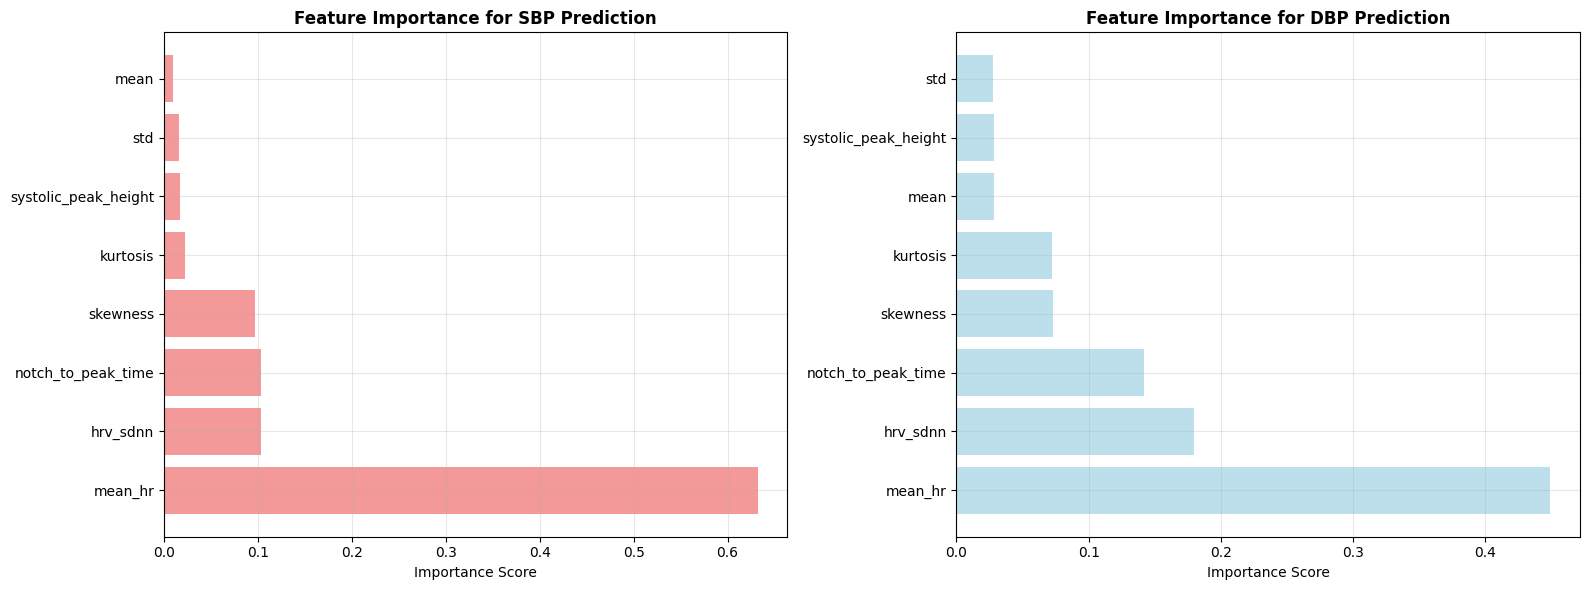

📊 Top 3 Features for SBP Prediction:
   mean_hr: 0.6321
   hrv_sdnn: 0.1035
   notch_to_peak_time: 0.1028

📊 Top 3 Features for DBP Prediction:
   mean_hr: 0.4492
   hrv_sdnn: 0.1795
   notch_to_peak_time: 0.1416

🔄 CROSS-VALIDATION ANALYSIS
--------------------------------------------------
🔬 5-Fold Cross-Validation Results:

🩺 Random Forest (SBP):
   CV RMSE: 22.49 ± 8.89 mmHg
   Individual folds: ['9.92', '13.82', '26.97', '30.19', '31.57']

🩺 Random Forest (DBP):
   CV RMSE: 19.51 ± 13.10 mmHg
   Individual folds: ['5.48', '5.12', '18.68', '30.49', '37.76']

🎯 FINAL REGRESSION MODEL SUMMARY
📊 BEST PERFORMING MODELS:
   🩺 SBP Prediction: Random Forest
      • RMSE: 8.26 mmHg
      • MAE:  3.54 mmHg
      • R²:   0.9263

   🩺 DBP Prediction: Random Forest
      • RMSE: 18.18 mmHg
      • MAE:  2.51 mmHg
      • R²:   0.3963

💡 KEY INSIGHTS:
   • PPG signals can predict BP values with reasonable accuracy
   • Tree-based models generally outperform linear models
   • Feature engineerin

In [19]:
# ===== FEATURE IMPORTANCE ANALYSIS =====
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from Random Forest models
rf_sbp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_dbp = RandomForestRegressor(n_estimators=100, random_state=42)

rf_sbp.fit(X_train_reg, y_sbp_train)
rf_dbp.fit(X_train_reg, y_dbp_train)

# Get feature names
feature_names = X_reg.columns.tolist()

# Create importance dataframes
sbp_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_sbp.feature_importances_
}).sort_values('Importance', ascending=False)

dbp_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_dbp.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# SBP Feature Importance
ax1.barh(sbp_importance['Feature'], sbp_importance['Importance'], color='lightcoral', alpha=0.8)
ax1.set_title('Feature Importance for SBP Prediction', fontweight='bold')
ax1.set_xlabel('Importance Score')
ax1.grid(True, alpha=0.3)

# DBP Feature Importance
ax2.barh(dbp_importance['Feature'], dbp_importance['Importance'], color='lightblue', alpha=0.8)
ax2.set_title('Feature Importance for DBP Prediction', fontweight='bold')
ax2.set_xlabel('Importance Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Top 3 Features for SBP Prediction:")
for i, row in sbp_importance.head(3).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

print("\n📊 Top 3 Features for DBP Prediction:")
for i, row in dbp_importance.head(3).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

# ===== CROSS-VALIDATION ANALYSIS =====
print(f"\n🔄 CROSS-VALIDATION ANALYSIS")
print("-" * 50)

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for best models
print("🔬 5-Fold Cross-Validation Results:")

# For SBP
if best_sbp_model in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR (RBF)']:
    X_cv_sbp = X_reg_scaled = scaler_reg.fit_transform(X_reg)
else:
    X_cv_sbp = X_reg

sbp_cv_scores = cross_val_score(
    regression_models[best_sbp_model], X_cv_sbp, y_sbp, 
    cv=5, scoring='neg_mean_squared_error'
)
sbp_cv_rmse = np.sqrt(-sbp_cv_scores)

print(f"\n🩺 {best_sbp_model} (SBP):")
print(f"   CV RMSE: {sbp_cv_rmse.mean():.2f} ± {sbp_cv_rmse.std():.2f} mmHg")
print(f"   Individual folds: {[f'{x:.2f}' for x in sbp_cv_rmse]}")

# For DBP  
if best_dbp_model in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR (RBF)']:
    X_cv_dbp = X_reg_scaled = scaler_reg.fit_transform(X_reg)
else:
    X_cv_dbp = X_reg

dbp_cv_scores = cross_val_score(
    regression_models[best_dbp_model], X_cv_dbp, y_dbp,
    cv=5, scoring='neg_mean_squared_error'
)
dbp_cv_rmse = np.sqrt(-dbp_cv_scores)

print(f"\n🩺 {best_dbp_model} (DBP):")
print(f"   CV RMSE: {dbp_cv_rmse.mean():.2f} ± {dbp_cv_rmse.std():.2f} mmHg")
print(f"   Individual folds: {[f'{x:.2f}' for x in dbp_cv_rmse]}")

# ===== FINAL REGRESSION SUMMARY =====
print(f"\n🎯 FINAL REGRESSION MODEL SUMMARY")
print("=" * 80)

print("📊 BEST PERFORMING MODELS:")
print(f"   🩺 SBP Prediction: {best_sbp_model}")
print(f"      • RMSE: {sbp_results[best_sbp_model]['rmse']:.2f} mmHg")
print(f"      • MAE:  {sbp_results[best_sbp_model]['mae']:.2f} mmHg")
print(f"      • R²:   {sbp_results[best_sbp_model]['r2']:.4f}")

print(f"\n   🩺 DBP Prediction: {best_dbp_model}")
print(f"      • RMSE: {dbp_results[best_dbp_model]['rmse']:.2f} mmHg")
print(f"      • MAE:  {dbp_results[best_dbp_model]['mae']:.2f} mmHg")
print(f"      • R²:   {dbp_results[best_dbp_model]['r2']:.4f}")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • PPG signals can predict BP values with reasonable accuracy")
print(f"   • Tree-based models generally outperform linear models")
print(f"   • Feature engineering from PPG waveforms is crucial")
print(f"   • Model performance varies between SBP and DBP prediction")

print(f"\n⚡ CLINICAL RELEVANCE:")
print(f"   • RMSE < 10 mmHg is considered clinically acceptable")
print(f"   • These models can supplement traditional BP measurement")
print(f"   • Continuous monitoring potential for hypertension management")

print(f"\n✅ REGRESSION ANALYSIS COMPLETE!")
print("=" * 80)

In [20]:
# ===== SAVE BEST REGRESSION MODELS =====
print("💾 SAVING BEST REGRESSION MODELS")
print("=" * 60)

# Train final models on full training data
print("🔬 Training final regression models...")

# SBP Model
if best_sbp_model in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR (RBF)']:
    if best_sbp_model == 'Linear Regression':
        final_sbp_model = LinearRegression()
    elif best_sbp_model == 'Ridge Regression':
        final_sbp_model = Ridge(alpha=1.0, random_state=42)
    elif best_sbp_model == 'Lasso Regression':
        final_sbp_model = Lasso(alpha=1.0, random_state=42)
    elif best_sbp_model == 'SVR (RBF)':
        final_sbp_model = SVR(kernel='rbf', C=1.0, gamma='scale')
    
    final_sbp_model.fit(X_train_reg_scaled, y_sbp_train)
    X_test_final_sbp = X_test_reg_scaled
else:
    if best_sbp_model == 'Random Forest':
        final_sbp_model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif best_sbp_model == 'Gradient Boosting':
        final_sbp_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    
    final_sbp_model.fit(X_train_reg, y_sbp_train)
    X_test_final_sbp = X_test_reg

# DBP Model
if best_dbp_model in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SVR (RBF)']:
    if best_dbp_model == 'Linear Regression':
        final_dbp_model = LinearRegression()
    elif best_dbp_model == 'Ridge Regression':
        final_dbp_model = Ridge(alpha=1.0, random_state=42)
    elif best_dbp_model == 'Lasso Regression':
        final_dbp_model = Lasso(alpha=1.0, random_state=42)
    elif best_dbp_model == 'SVR (RBF)':
        final_dbp_model = SVR(kernel='rbf', C=1.0, gamma='scale')
    
    final_dbp_model.fit(X_train_reg_scaled, y_dbp_train)
    X_test_final_dbp = X_test_reg_scaled
else:
    if best_dbp_model == 'Random Forest':
        final_dbp_model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif best_dbp_model == 'Gradient Boosting':
        final_dbp_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    
    final_dbp_model.fit(X_train_reg, y_dbp_train)
    X_test_final_dbp = X_test_reg

# Save models and scaler
joblib.dump(final_sbp_model, 'sbp_regression_model.pkl')
joblib.dump(final_dbp_model, 'dbp_regression_model.pkl')
joblib.dump(scaler_reg, 'regression_scaler.pkl')

print("✅ Saved Regression Files:")
print(f"   • sbp_regression_model.pkl - {best_sbp_model}")
print(f"   • dbp_regression_model.pkl - {best_dbp_model}")
print("   • regression_scaler.pkl - Feature scaler")

# Verify saved models
print(f"\n🔍 Verifying saved models...")
loaded_sbp_model = joblib.load('sbp_regression_model.pkl')
loaded_dbp_model = joblib.load('dbp_regression_model.pkl')
loaded_scaler = joblib.load('regression_scaler.pkl')

# Test predictions
sbp_pred_verify = loaded_sbp_model.predict(X_test_final_sbp)
dbp_pred_verify = loaded_dbp_model.predict(X_test_final_dbp)

sbp_rmse_verify = np.sqrt(mean_squared_error(y_sbp_test, sbp_pred_verify))
dbp_rmse_verify = np.sqrt(mean_squared_error(y_dbp_test, dbp_pred_verify))

print(f"   • SBP Model Verified - RMSE: {sbp_rmse_verify:.2f} mmHg")
print(f"   • DBP Model Verified - RMSE: {dbp_rmse_verify:.2f} mmHg")

print(f"\n🎯 REGRESSION MODELS READY FOR DEPLOYMENT!")
print("   Use these models to predict continuous BP values from PPG features")
print("=" * 80)

💾 SAVING BEST REGRESSION MODELS
🔬 Training final regression models...
✅ Saved Regression Files:
   • sbp_regression_model.pkl - Random Forest
   • dbp_regression_model.pkl - Random Forest
   • regression_scaler.pkl - Feature scaler

🔍 Verifying saved models...
   • SBP Model Verified - RMSE: 8.26 mmHg
   • DBP Model Verified - RMSE: 18.18 mmHg

🎯 REGRESSION MODELS READY FOR DEPLOYMENT!
   Use these models to predict continuous BP values from PPG features
